# Test Predictor

In [51]:
import os
#os.chdir("Arena")

from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import dataset
from Prediction import kalman_predict
from Prediction import seq2seq_predict
import imp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [3]:
det = detector.Detector_v4()

Detector initiated successfully


## Kalman Predictor

In [391]:
kalman_predictor = kalman_predict.ConstantVelocityKalmanPredictor(forecast_horizon=20)
p = predictor.HitPredictor(traj_predictor, det, history_size=5288)

In [24]:
imp.reload(visualize)

vid_path = "../../Pogona_Pursuit/Arena/experiments/fast_cockroach_line_20200730T131606/trial1/videos/20200730-131607/19506468.avi"
out_path = "labelled/test_kalman_predictor.mp4"

p.reset(history_size=5288)
visualize.process_video(vid_path, out_path, [visualize.predictor_visualizer(p)])

100%|██████████| 5080/5080 [02:24<00:00, 35.25it/s]


# Train Trajectory Predictor

In [4]:
import torch
from Prediction import dataset
from Prediction import seq2seq_predict as lstm
from Prediction import train_eval
import numpy as np
import pandas as pd
import pickle
import imp

In [4]:
def plot_train_results(results_list, title):
    fig, axs = plt.subplots(3, figsize=(10,20))
    fig.suptitle(title)

    axs[0].set_ylabel("ADE")
    axs[1].set_ylabel("FDE")
    axs[2].set_ylabel("loss")
    
    for (losses, ADEs, FDEs, name) in results_list:
        axs[0].plot(list(ADEs.values()), label=name)
        axs[0].legend()
        axs[1].plot(list(FDEs.values()), label=name)
        axs[1].legend()
        axs[2].plot(losses, label=name)
        axs[2].legend()        

In [449]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(lstm)
imp.reload(LSTM_predict)
imp.reload(predictor)
imp.reload(visualize)
#imp.reload(detector)
imp.reload(dataset)

<module 'Prediction.dataset' from '/app/Pogona_realtime/Arena/Prediction/dataset.py'>

## Single training session

In [6]:
all_df = dataset.get_unified_dataframe((1440,1080), multi_index=True)
results = []

exclude_trials = [
    ('circle_20200803T084227', 2),
    ('line_20200803T101641', 1),
    ('line_20200803T081735', 1),
    ('line_20200803T082002', 1),
    ('line_20200803T101641', 2),
]
all_trials = list(all_df.index.unique())
trials = list(set(all_trials) - set(exclude_trials))
train, val, test = train_eval.create_train_val_test_splits(trials, [0.8, 0.2, 0])

skipped ../../Pogona_Pursuit/Arena/experiments/initial_20200727T071226, ignored word
skipped ../../Pogona_Pursuit/Arena/experiments/initial_20200727T073708, ignored word
did not find files in ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358 trial1
did not find files in ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358 trial2
did not find files in ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358 trial3
did not find files in ../../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358 trial4
skipped ../../Pogona_Pursuit/Arena/experiments/fps_check_20200727T083454, ignored word
did not find files in ../../Pogona_Pursuit/Arena/experiments/test_20200727T100404 trial1
skipped ../../Pogona_Pursuit/Arena/experiments/test_fps_20200727T102701, ignored word
skipped ../../Pogona_Pursuit/Arena/experiments/fps_check_20200727T105124, ignored word
skipped ../../Pogona_Pursuit/Arena/experiments/fps_check_20200727T110833, ignored word
skipped ../../Pogona_P

In [7]:
train, val, test

([('circle_20200803T120911', 1),
  ('circle_20200803T084529', 2),
  ('circle_20200803T121730', 1),
  ('line_20200803T095401', 1),
  ('circle_20200803T092248', 1),
  ('line_20200803T094928', 1),
  ('fast_line_20200803T082724', 1),
  ('line_20200803T114942', 1),
  ('line_20200803T122506', 1),
  ('circle_20200803T113121', 1),
  ('circle_20200803T084227', 1),
  ('fast_line_20200803T082414', 1),
  ('circle_20200803T093051', 1),
  ('circle_20200803T090234', 1),
  ('circle_20200803T091639', 1),
  ('circle_20200803T090615', 1)],
 [('circle_20200803T084529', 1),
  ('fast_cockroach_20200803T085738', 1),
  ('circle_20200803T115839', 1),
  ('line_20200803T081429', 1)],
 [])

In [440]:
results=[]
input_labels = ['cent_x', 'cent_y', 'w', 'h']

output_labels = ['cent_x', 'cent_y']
input_dim = len(input_labels)
output_dim = len(output_labels)

inp_seq_len = 20
out_seq_len = 20
embedding_size = 4
hidden_size = 64
batch_size = 64
rnn_layers = 1

In [427]:
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(
    all_df, train, val, test, input_labels, output_labels, inp_seq_len, 
    out_seq_len, batch_size=batch_size, std_threshold=1, keep_lowvar_prob=0.2)

In [399]:
len(train_dl) * batch_size

50304

In [432]:
net = lstm.LSTMdense(input_dim,output_dim,
                     out_seq_len, hidden_size=hidden_size, 
                     embedding_size=embedding_size, LSTM_layers=rnn_layers)

In [416]:
net = lstm.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                     tie_enc_dec=True, dropout=0.4)

In [338]:
net = lstm.GRUPositionEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, embedding_size=embedding_size,
                             GRU_layers=rnn_layers, dropout=0.4)

In [450]:
net = lstm.VelLinear(input_size=input_dim, output_size=output_dim, input_seq_size=inp_seq_len, output_seq_size=out_seq_len, hidden_size=hidden_size, dropout=0.4)

In [451]:
model_name=f"model_{inp_seq_len}_{out_seq_len}_h{hidden_size}_b{batch_size}_l{rnn_layers}_VelLinear"
best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(
    net, train_dl, val_dl, 100, 'Prediction/traj_models/', clip_grad_norm=1,
    eval_freq=5, epoch_print_freq=5, model_name=model_name, save_each_eval_model=False)

results.append((losses, ADEs, FDEs, f"GRU h{hidden_size}"))

Epoch: 1, avg loss: 4.544, epoch time: 1.183
### Eval epoch: 1, Test set mean ADE: 6.363, mean FDE: 10.626
Epoch: 6, avg loss: 4.483, epoch time: 1.156
### Eval epoch: 6, Test set mean ADE: 6.240, mean FDE: 10.469
Epoch: 11, avg loss: 4.461, epoch time: 1.169
### Eval epoch: 11, Test set mean ADE: 6.287, mean FDE: 10.532
Epoch: 16, avg loss: 4.456, epoch time: 1.190
### Eval epoch: 16, Test set mean ADE: 6.290, mean FDE: 10.559
Epoch: 21, avg loss: 4.447, epoch time: 1.159
### Eval epoch: 21, Test set mean ADE: 6.283, mean FDE: 10.549
Epoch: 26, avg loss: 4.436, epoch time: 1.197
### Eval epoch: 26, Test set mean ADE: 6.338, mean FDE: 10.634
Epoch: 31, avg loss: 4.433, epoch time: 1.164
### Eval epoch: 31, Test set mean ADE: 6.214, mean FDE: 10.453
Epoch: 36, avg loss: 4.415, epoch time: 1.165
### Eval epoch: 36, Test set mean ADE: 6.293, mean FDE: 10.589
Epoch: 41, avg loss: 4.417, epoch time: 1.191
### Eval epoch: 41, Test set mean ADE: 6.226, mean FDE: 10.469
Epoch: 46, avg loss: 4.

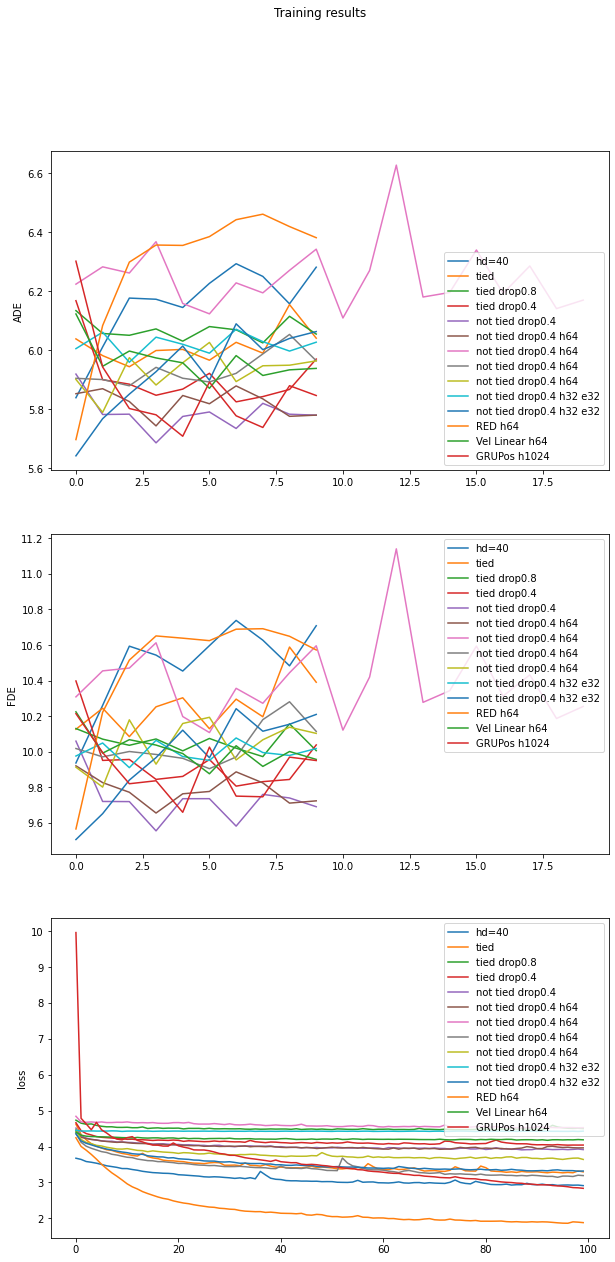

In [340]:
plot_train_results(results, "Training results")

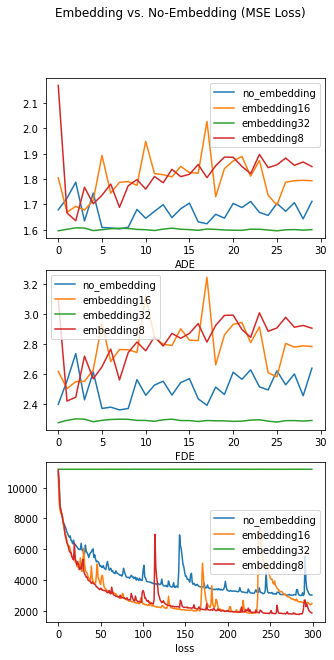

In [127]:
mse_results
plot_train_results(mse_results, "Embedding vs. No-Embedding (MSE Loss)")

## Test RED (lstm+dense) Predictor

In [458]:
imp.reload(LSTM_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(dataset)
imp.reload(train_eval)

<module 'Prediction.train_eval' from '/app/Pogona_realtime/Arena/Prediction/train_eval.py'>

In [11]:
EXP_BASE = '../../Pogona_Pursuit/Arena/experiments/'

In [434]:
model_path = 'Prediction/traj_models/RED/model_20_20_h64_b64_l1_RED_41_best.pth'

red_predictor = LSTM_predict.REDPredictor(model_path, 20, 20, hidden_size=hidden_size,
                                          embedding_size=embedding_size, LSTM_layers=rnn_layers)
red_hitp = predictor.HitPredictor(red_predictor, det, history_size=5288, prediction_y_threshold=900)

In [536]:
trial = val[1]
vid_path,_ = dataset.get_trial_path(os.path.join(EXP_BASE,trial[0]),1)
bboxes = all_df.loc[trial][['x','y','w','h']].values
out_path = "../labelled/test_h16_best.mp4"

red_hitp.reset(history_size=5288)
visualize.process_video(vid_path, out_path, [visualize.offline_predictor_visualizer(red_hitp,bboxes)])

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [459]:
model_path = 'Prediction/traj_models/model_20_20_h64_b64_l1_VelLinear_56_best.pth'
model = lstm.VelLinear(input_size=input_dim, output_size=output_dim, input_seq_size=inp_seq_len, output_seq_size=out_seq_len, hidden_size=hidden_size, dropout=0.4)
lin_predictor = LSTM_predict.Seq2SeqPredictor(model, model_path, inp_seq_len, out_seq_len)

In [419]:
model_path = 'Prediction/traj_models/GRUEncDec/model_20_20_h64_b64_l1_GRU_16_best.pth'
model = lstm.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers)
#model = lstm.GRUPositionEncDec(output_seq_size=out_seq_len, hidden_size=32, embedding_size=32,
#                             GRU_layers=1, dropout=0.4)
gru_predictor = LSTM_predict.Seq2SeqPredictor(model, model_path, inp_seq_len, out_seq_len)
hit_predictor = predictor.HitPredictor(traj_predictor, det, history_size=5288, prediction_y_threshold=900)

In [349]:
trial = val[1]
vid_path,_ = dataset.get_trial_path(os.path.join(EXP_BASE,trial[0]),1)
bboxes = all_df.loc[trial][['x','y','w','h']].values
out_path = "../labelled/test_gru9_pos32.mp4"

hit_predictor.reset(history_size=5288)
visualize.process_video(vid_path, out_path, [visualize.offline_predictor_visualizer(hit_predictor, bboxes)])

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
torch.backends.cudnn.benchmark = True

In [19]:
d_model = 32
trans = torch.nn.Transformer(d_model=d_model, 
                             nhead=2, 
                             num_encoder_layers=2, 
                             num_decoder_layers=2, dim_feedforward=32).to('cuda').float().half()

In [21]:
x = torch.rand(20,1,d_model).to('cuda').float().half()

In [11]:
%timeit trans(x,x)

4.16 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit trans(x,x) # half

4.11 ms ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
gru_test = torch.nn.GRU(input_size=16, hidden_size=64).to('cuda')

In [33]:
x = torch.rand(20,1,16).to('cuda')

In [41]:
%timeit gru_test(x)

276 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
gru_cell = torch.nn.GRUCell(16,64).to('cuda')

In [44]:
def f(x):
    for k in range(20):
        gru_cell(x)

In [46]:
%timeit f(x[0])

1.6 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Evaluate trajectory predictor

In [460]:
bboxes = all_df.loc[val[1]][['x','y','w','h']].values
train_eval.eval_trajectory_predictor(lin_predictor, bboxes)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


{'avg ADE': 4.918572214125697,
 'avg FDE': 8.726261107909222,
 'avg time (ms)': 0.28816607054762955}

- gru = 4.78/8.46 (3.8ms)
- red = 4.88/8.62 (0.6ms)
- vel_linear = 4.91/8.72 (0.2ms)
- kalman = 6.8852/13.116 (0.09ms)

## Hyper-parameter search (input and output sequence lengths)

In [222]:
inp_lens = range(12, 49, 8)
out_lens = inp_lens

ADEs = train_eval.grid_input_output(lstm.LSTMdense, all_df, inp_lens, out_lens, inp_labels, out_labels, 'Prediction/traj_models/RED/', 401)

Training with input_seq_len=12, output_seq_len=12
epoch: 0, loss: 777.553, epoch time: 1.367
++++++++++++++++
Eval epoch: 0, Test set mean ADE 2.219
epoch: 50, loss: 337.948, epoch time: 1.450
epoch: 100, loss: 268.827, epoch time: 1.472
++++++++++++++++
Eval epoch: 100, Test set mean ADE 2.496
epoch: 150, loss: 241.172, epoch time: 1.438
epoch: 200, loss: 227.790, epoch time: 1.429
++++++++++++++++
Eval epoch: 200, Test set mean ADE 2.527
epoch: 250, loss: 219.896, epoch time: 1.480
epoch: 300, loss: 214.207, epoch time: 1.455
++++++++++++++++
Eval epoch: 300, Test set mean ADE 2.549
epoch: 350, loss: 210.148, epoch time: 1.434
epoch: 400, loss: 206.672, epoch time: 1.524
++++++++++++++++
Eval epoch: 400, Test set mean ADE 2.563
Finished training
Training with input_seq_len=12, output_seq_len=20
epoch: 0, loss: 1068.994, epoch time: 1.496
++++++++++++++++
Eval epoch: 0, Test set mean ADE 2.946
epoch: 50, loss: 444.467, epoch time: 1.441
epoch: 100, loss: 335.257, epoch time: 1.513
+++

In [256]:
ADEs = ADEs.astype('float64')

In [257]:
ADEs.values

array([[2.2193172 , 2.94573975, 3.66684103, 4.36968851, 4.93245792],
       [2.193115  , 2.93659759, 3.61216402, 4.30841875, 4.86428928],
       [2.17989755, 2.90543628, 3.60302877, 4.27222824, 4.90603304],
       [2.18515611, 2.88209367, 3.57404041, 4.25071716, 4.84111214],
       [2.16800404, 2.9057312 , 3.58273959, 4.23318243, 4.79080868]])

In [261]:
ADEs

,12,20,28,36,44
12,2.219317,2.945740,3.666841,4.369689,4.932458
20,2.193115,2.936598,3.612164,4.308419,4.864289
28,2.179898,2.905436,3.603029,4.272228,4.906033
36,2.185156,2.882094,3.574040,4.250717,4.841112
44,2.168004,2.905731,3.582740,4.233182,4.790809


Text(0, 0.5, 'input length')

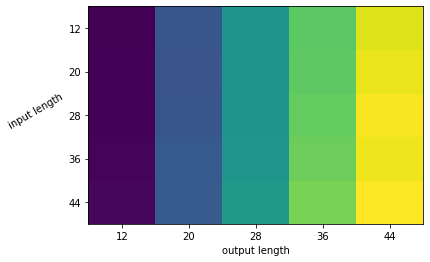

In [278]:
plt.pcolor(ADEs)
plt.yticks(np.arange(0.5, len(ADEs.index), 1)[::-1], ADEs.columns)
plt.xticks(np.arange(0.5, len(ADEs.columns), 1), ADEs.index)
plt.xlabel('output length')
plt.ylabel('input length',rotation=30,labelpad=30)

In [275]:
ADEs

,12,20,28,36,44
12,2.219317,2.945740,3.666841,4.369689,4.932458
20,2.193115,2.936598,3.612164,4.308419,4.864289
28,2.179898,2.905436,3.603029,4.272228,4.906033
36,2.185156,2.882094,3.574040,4.250717,4.841112
44,2.168004,2.905731,3.582740,4.233182,4.790809


In [16]:
import Prediction.LSTM_predict as lstm

In [18]:
net.eval()

LSTMdense(
  (LSTM): LSTM(2, 256, num_layers=2)
  (dense): Linear(in_features=256, out_features=48, bias=True)
)

In [26]:
total_ADE = 0
count = 0
device = torch.device('cuda')
for (x, y) in train_dataloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = net(x)

    total_ADE += lstm.calc_ADE(pred, y)
    count += 1

print("++++++++++++++++")
print(f"Test set mean ADE {total_ADE/count:.3f}")


++++++++++++++++
Test set mean ADE 3.694


In [77]:
net.output_seq_size

12

In [96]:
x,y = iter(train_dataloader).next()

In [79]:
import glob

In [82]:
x=5
f"{x} - bla"

'5 - bla'

In [46]:
x = torch.randint(low=0,high=15,size=(3,8,6))

In [47]:
x

tensor([[[ 1,  7,  3,  5, 14, 14],
         [ 9, 14,  6, 11, 11,  8],
         [12,  8,  9,  5,  2,  4],
         [ 4,  6,  6,  3,  5,  4],
         [ 1,  2, 12, 14, 10,  4],
         [ 7, 14, 11,  1,  0,  7],
         [14,  0,  7,  1,  9,  6],
         [13,  2, 13, 10,  5, 14]],

        [[13, 12,  2, 14,  4,  3],
         [13,  1,  3,  8,  5,  9],
         [14,  3,  8, 10,  6, 13],
         [ 8, 13, 14,  3, 10, 12],
         [ 2,  6,  3,  0, 13, 13],
         [ 8, 12,  0,  8, 13, 12],
         [ 0,  4,  7,  7,  6, 13],
         [13,  8,  4,  2,  0, 10]],

        [[13,  1, 11,  1,  2,  1],
         [ 8, 10, 10, 13,  8,  8],
         [ 5,  4,  2,  7, 13,  3],
         [ 9, 10, 14, 12,  2,  4],
         [ 0,  9,  4,  6,  2,  3],
         [ 9,  4,  1, 10,  6, 14],
         [14,  8,  3,  1,  7,  3],
         [ 5, 13, 13,  8,  5, 14]]])

In [49]:
diffs = x[:, 1:, :2] - x[:, :-1, :2]

In [218]:
torch.cat([diffs, x[:, 1:, 2:]], dim=2).transpose(0,1)

NameError: name 'diffs' is not defined

In [221]:
val

[('circle_20200803T090234', 1),
 ('line_20200803T122506', 1),
 ('line_20200803T114942', 1),
 ('circle_20200803T093051', 1),
 ('line_20200803T094928', 1)]

In [252]:
thresh = 20
import seaborn as sns
exper_list = test
#fig, axs = plt.subplots(len(exper_list), figsize=(10,10 * len(exper_list)))

for i, trial in enumerate(exper_list):
    df = all_df.loc[trial]
    xy = df[['cent_x', 'cent_y']]
    vxvy = df[['cent_x','cent_y']].diff()
    norms = np.linalg.norm(xy,axis=1)
    norms = norms[~np.isnan(norms)]
    print(trial)
    print(np.sqrt(np.var(xy)))
    #sns.distplot(xy,bins=100,kde=True, hist=True, ax=axs[i])

('circle_20200803T084529', 2)
cent_x    18.144809
cent_y    12.600981
dtype: float64
('line_20200803T095401', 1)
cent_x    21.449594
cent_y    11.922905
dtype: float64


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  import sys


# Worthless trials:

- ('circle_20200803T084227', 2)
- ('line_20200803T101641', 1)
- ('line_20200803T081735', 1)
- ('line_20200803T082002', 1)
- ('line_20200803T101641', 2)

In [378]:
X, Y = train_eval.trial_to_samples(all_df.loc[train[0]], input_labels=input_labels, output_labels=output_labels,
                                input_seq_size=inp_seq_len, output_seq_size=out_seq_len, std_threshold=1)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


In [464]:
XY = torch.cat((X[:,:,:2],Y),dim=1)

In [467]:
XYmean = XY.mean(dim=1).repeat(XY.shape[1], 1, 1).transpose(0, 1)

In [475]:
XYnorms = (XY - XYmean).norm(dim=2)

In [479]:
XYvar = XYnorms.var(dim=1)
XYvar

tensor([192.0864, 292.8136, 397.4197,  ...,   7.8326,   6.6571,   5.4736])

In [476]:
XY.shape, XYnorms.shape

(torch.Size([1136, 28, 2]), torch.Size([1136, 28]))

In [501]:
torch.rand(1) < 0.2

tensor([False])

In [246]:
pe = lstm.PositionalEncoding(8)

In [239]:
pe(torch.tensor([[[1,2,3,4,5,6]], [[1,2,3,4,5,6]]]).float())

tensor([[[1.1111, 3.3333, 3.3333, 5.5556, 5.5556, 7.7778]],

        [[2.0461, 0.0000, 3.3849, 5.5544, 5.5579, 7.7778]]])

In [240]:
lin = torch.nn.Linear(in_features=2, out_features=8)

In [248]:
pe(lin(torch.tensor([[[1.,1.],[2.,2.]],[[1.,1.],[2.,2.]]])))

RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

In [359]:
wh = all_df[train[0]]

KeyError: ('circle_20200803T120911', 1)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


array([[714.53623581, 820.18471909, 100.59122467, 110.3239212 ],
       [713.96570587, 819.54024506, 101.23728943, 111.20429993],
       [714.74464798, 820.38799286, 101.87837982, 110.06288147],
       ...,
       [512.33658981, 751.1159935 , 117.37772369,  96.84064484],
       [511.61778259, 753.13035965, 117.65371704,  95.39772797],
       [512.13025284, 753.88074493, 117.3012619 ,  95.60472107]])

In [320]:
wh = wh.dropna()

In [309]:
varwh

w    131.259099
h    106.737063
dtype: float64

(array([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.1000e+01,
         2.6000e+01, 4.9000e+01, 8.0000e+00, 9.0000e+00, 3.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 1.1600e+02, 4.9600e+02,
         1.6100e+03, 2.5010e+03, 8.9000e+01, 2.3000e+01, 1.7000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0100e+02, 1.2970e+03,
         7.9200e+03, 9.5140e+03, 1.2500e+03, 3.2000e+01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0000e+00, 2.2200e+02, 2.2420e+03,
         1.1511e+04, 7.6510e+03, 6.2550e+03, 9.6500e+02, 4.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.0000e+00, 3.9100e+02, 9.4100e+02,
         6.1560e+03, 5.9920e+03, 9.9290e+03, 2.5330e+03, 1.8000e+01],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 3.7100e+02,
         5.1980e+03, 8.0760e+03, 1.1080e+04, 1.2720e+03, 1.7000e+01],
        [0.0000e+00, 0.0000

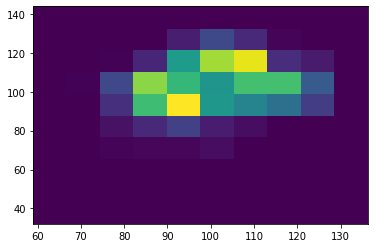

In [321]:
plt.hist2d(wh.iloc[:, 0], wh.iloc[:, 1])